In [23]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import time

In [103]:
images = ['../Data/528.jpeg', '../Data/1084.jpg', '../Data/12146_И6125.jpg', '../Data/1753.jpeg', '../Data/12245_И6774.jpg',
          '../Data/12145_И6666.jpg', '../Data/1038.jpg']
image = images[6]

In [104]:
im = cv2.cvtColor(cv2.imread(image), cv2.COLOR_BGR2RGB)

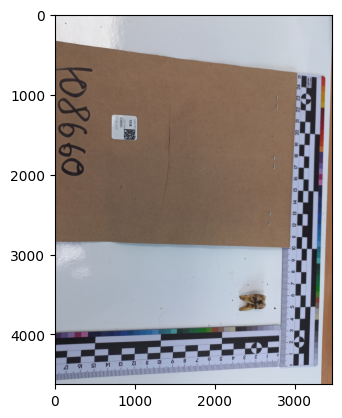

In [105]:
plt.imshow(im)
plt.show()

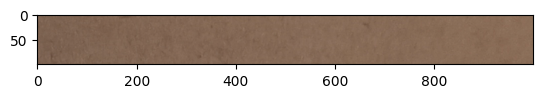

In [106]:
im_hsv = cv2.cvtColor(im, cv2.COLOR_BGR2HSV)
plt.imshow(cv2.cvtColor(im_hsv[1600:1700, 1700:2700], cv2.COLOR_HSV2BGR))

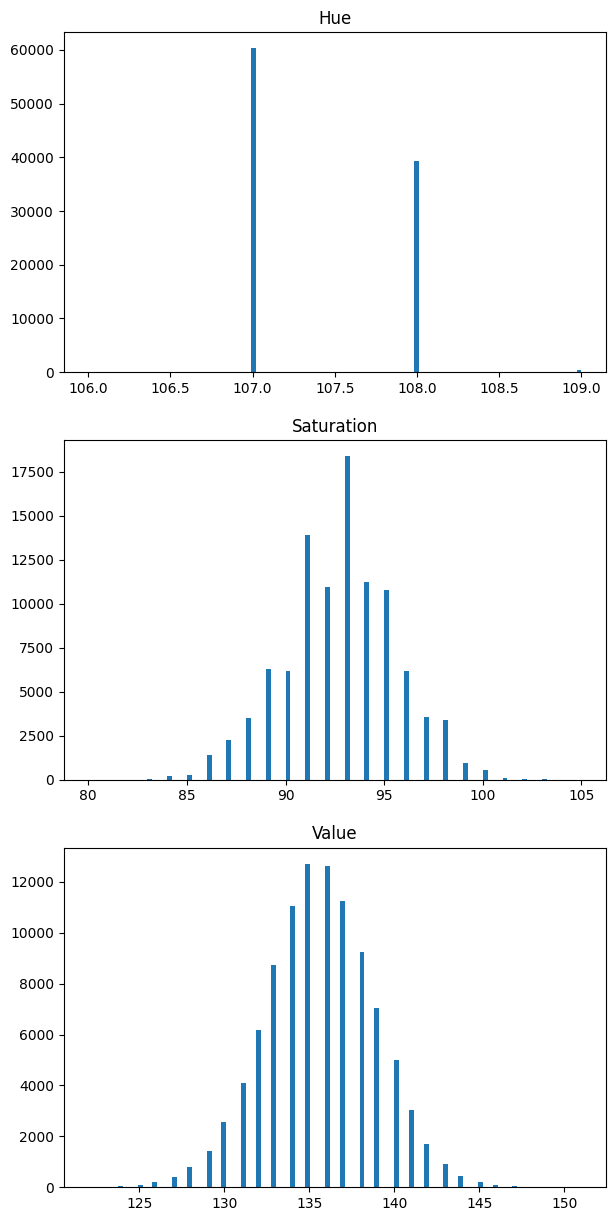

In [107]:
crop = im_hsv[1000:1500, 2200:2400] 
fig, ax = plt.subplots(3,1, figsize=(7,15))
ax = ax.ravel()
d = dict({0: 'Hue',
          1: 'Saturation',
          2: 'Value'})
for i in range(3):
    ax[i].hist(crop[:,:,i].ravel(),bins=100)
    ax[i].set_title(d[i])
    
plt.show()

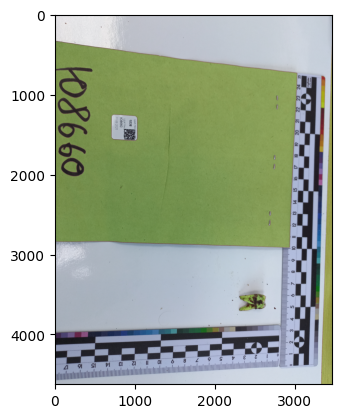

In [108]:
#packet_mask = cv2.inRange(cv2.blur(im_hsv, (5,5)), (93,70,50), (120,255,200))
packet_mask = cv2.inRange(cv2.blur(im_hsv, (21,21)), (93,70,100), (120,255,200))
eroded = cv2.morphologyEx(packet_mask, cv2.MORPH_CLOSE, (5,5))
eroded = cv2.morphologyEx(packet_mask, cv2.MORPH_OPEN, (5,5))
mask = np.zeros_like(im)
mask[eroded!=0] = np.array([0,255,0])
masked = cv2.addWeighted(im, 1, mask,0.2, 0)
plt.imshow(masked)
plt.show()

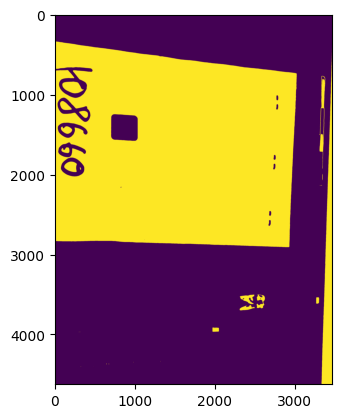

In [109]:
plt.imshow(packet_mask)
plt.show()

In [110]:
contours, _ = cv2.findContours(packet_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

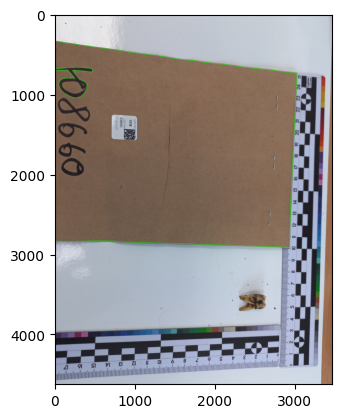

In [111]:
im2 = np.copy(im)



lengths = []
for i in contours:
    lengths.append(cv2.contourArea(i))
lengths = np.array(lengths)

m = lengths.argmax()

cv2.drawContours(im2, contours, m, (0,255,0), 3)


plt.imshow(im2)
plt.show()

In [112]:
lengths = []
for i in contours:
    lengths.append(cv2.contourArea(i))
lengths = np.array(lengths)

In [113]:
lengths.argmax()

16

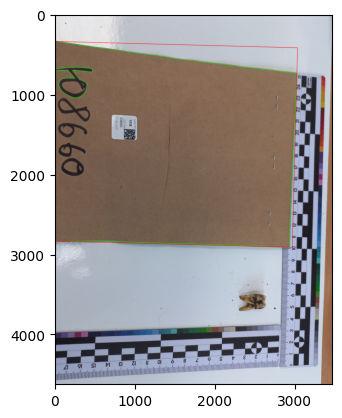

In [114]:
rect = cv2.minAreaRect(contours[lengths.argmax()])
box = cv2.boxPoints(rect)
box = np.intp(box) 
cv2.drawContours(im2,[box],0,(255,0,0),3)
plt.imshow(im2)

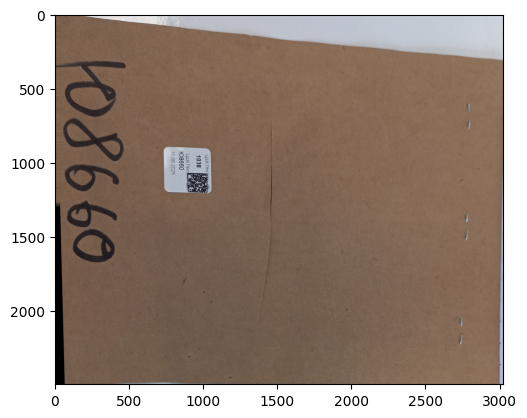

In [115]:
def crop_minAreaRect(img, rect):
# Get center, size, and angle from rect
    center, size, theta = rect
    # Convert to int 
    center, size = tuple(map(int, center)), tuple(map(int, size))
    # Get rotation matrix for rectangle
    M = cv2.getRotationMatrix2D( center, theta, 1)
    # Perform rotation on src image
    dst = cv2.warpAffine(img, M, img.shape[:2])
    out = cv2.getRectSubPix(dst, size, center)
    return out


cropped = crop_minAreaRect(im,rect)
plt.imshow(cropped)
plt.show()

In [116]:
rect

((1479.955078125, 1629.086669921875),
 (3026.295654296875, 2494.199462890625),
 1.501564621925354)

In [117]:
box

array([[ -65, 2836],
       [   0,  342],
       [3025,  422],
       [2959, 2915]])

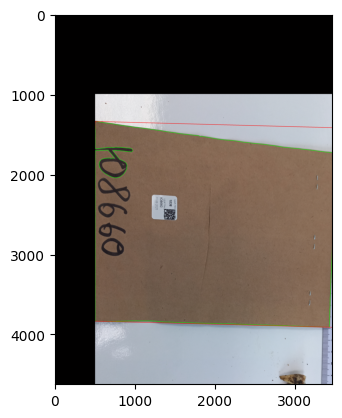

In [118]:
tx=500
ty=1000

translation_matrix = np.float32([
    [1, 0, tx],
    [0, 1, ty]
])


warp = cv2.warpAffine(im2, translation_matrix, (im.shape[1], im.shape[0]), borderValue=cv2.BORDER_REPLICATE)

plt.imshow(warp)
plt.show()

In [119]:
M = cv2.getRotationMatrix2D(rect[0], rect[2], 1)
M

array([[ 9.99656610e-01,  2.62042467e-02, -4.21807869e+01],
       [-2.62042467e-02,  9.99656610e-01,  3.93405205e+01]])

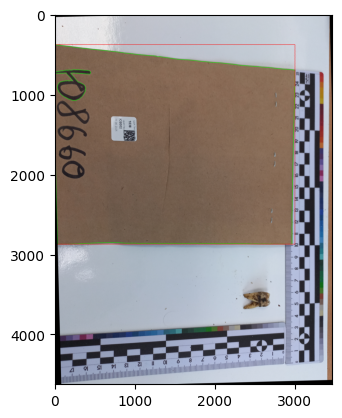

In [120]:
rotated = cv2.warpAffine(im2, M, (im2.shape[1], im2.shape[0]), borderValue=cv2.BORDER_REPLICATE)
plt.imshow(rotated)
plt.show()

In [121]:
b1 = np.intp(np.hstack((box,np.ones((4,1),dtype=np.int16)))@M.T)

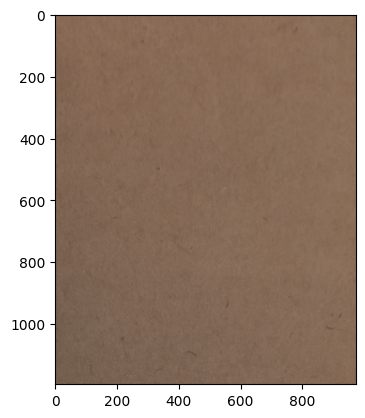

In [122]:
res = rotated[937:2132,1684:2657]
plt.imshow(res)
plt.show()

In [123]:
def cropped(img, rect):
    center, _, angle = rect
    height, width = img.shape[:2] 


    
    M = cv2.getRotationMatrix2D(center, angle,1)

    cos = np.abs(rotation_matrix[0, 0])
    sin = np.abs(rotation_matrix[0, 1])
    new_width = int((height * sin) + (width * cos))
    new_height = int((height * cos) + (width * sin))

    M[0, 2] += (new_width / 2) - center[0]
    M[1, 2] += (new_height / 2) - center[1]


    final_image = cv2.warpAffine(im2, M, (new_width + tx, new_height + ty)) 
    
    old_box = np.intp(cv2.boxPoints(rect))
    rotated = cv2.warpAffine(img, M, (img.shape[1], img.shape[0]), borderValue=cv2.BORDER_REPLICATE)
    new_box = np.hstack((old_box, np.ones((4,1)))) @ M.T
    new_box = np.intp(new_box)
    x_min = new_box[:,0].min()
    x_max = new_box[:,0].max()
    y_min = new_box[:,1].min()
    y_max = new_box[:,1].max()
    cropped = rotated[y_min:y_max, x_min:x_max]
    return cropped

ValueError: zero-size array to reduction operation minimum which has no identity

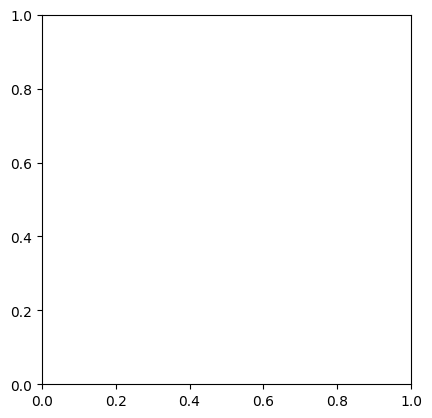

In [124]:
plt.imshow(cropped(im2,rect))
plt.show()

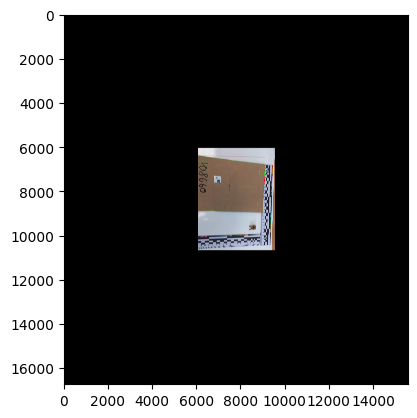

In [127]:
margin = round(max(rect[1])*2)
padded = cv2.copyMakeBorder(
    im2,
    top=margin,
    bottom=margin,
    left=margin,
    right=margin,
    borderType=cv2.BORDER_CONSTANT,
    value=(0, 0, 0)   # Black (BGR)
)

plt.imshow(padded)
plt.show()

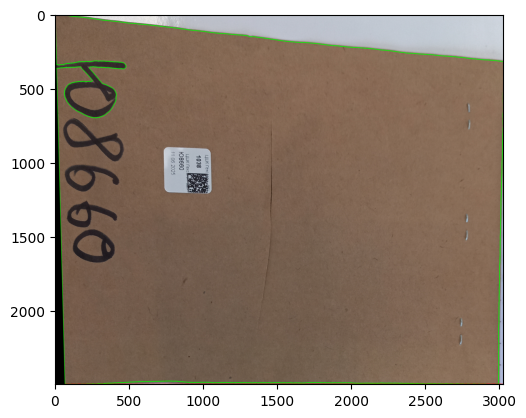

In [136]:
height, width = im2.shape[:2]
center = rect[0]
 
# Rotation parameters
angle = rect[2]  # degrees
scale = 1.0
 
# Translation values
tx, ty = 0, 0  # Shift right and down
 
# Step 1: Get basic rotation matrix
rotation_matrix = cv2.getRotationMatrix2D(center, angle, scale)



# Step 2: Compute new canvas size to avoid cropping
cos = np.abs(rotation_matrix[0, 0])
sin = np.abs(rotation_matrix[0, 1])
new_width = int((height * sin) + (width * cos))
new_height = int((height * cos) + (width * sin))
 
# Step 3: Adjust the rotation matrix to center the image on new canvas
rotation_matrix[0, 2] += (new_width / 2) - center[0]
rotation_matrix[1, 2] += (new_height / 2) - center[1]
 
# Step 4: Create translation matrix manually
#translation_matrix = np.float32([[1, 0, tx], [0, 1, ty]])
 
# Step 5: Combine both rotation and translation into a single affine matrix
# Convert to 3x3 matrix to multiply them
#rotation_3x3 = np.vstack([rotation_matrix, [0, 0, 1]])
#translation_3x3 = np.vstack([translation_matrix, [0, 0, 1]])
#combined_matrix = np.dot(translation_3x3, rotation_3x3)  # Apply rotation, then translation
#final_matrix = combined_matrix[:2, :]  # Convert back to 2x3 for warpAffine
 
# Step 6: Perform transformation
final_image = cv2.warpAffine(im2, rotation_matrix, (new_width + tx, new_height + ty))



old_box = np.intp(cv2.boxPoints(rect))
new_box = np.hstack((old_box, np.ones((4,1)))) @ rotation_matrix.T
new_box = np.intp(new_box)
x_min = new_box[:,0].min()
x_max = new_box[:,0].max()
y_min = new_box[:,1].min()
y_max = new_box[:,1].max()
cropped = final_image[y_min:y_max, x_min:x_max]





plt.imshow(cropped)
plt.show()